In [1]:
import pandas as pd
import sys

In [2]:
from src.utils.tree import SNPTreeParser
from src.utils.analysis import EpistasisFinder

In [3]:
bfile = 'path_to_your_genotype' # prefix for PLINK bfile ("https://www.cog-genomics.org/plink/1.9/input")
ont = 'path_to_ontology_file.txt'
snp2gene = 'path_to_snp2gene_file.txt'

In [4]:
tree_parser = SNPTreeParser(ont, snp2gene, sys_annot_file='GO_files/goID_2_name.tab')

2227 Systems are queried
963 Genes are queried
Total 9646 Gene-System interactions are queried
Building descendant dict
Subtree types:  ['default']


In [5]:
attention_result = 'path_to_attention_result_from_your_G2PT_prediction'

In [6]:
cov = 'path_to_covariate_file' # PLINK Covar file https://www.cog-genomics.org/plink/1.9/input

In [7]:
epistasis_finder = EpistasisFinder(tree_parser, bfile, attention_results=attention_result, cov=cov, flip=True)

Swapping Ref and Alt!
From PLINK 4019 variants with 317007 samples are queried


In [8]:
target_system = 'GO:0015914'

# 1. Epistasis Search in Target System

In [9]:
# set verbose=1 if you want to detailed statistical result (not recommended for large system)
epistasis_results, snp_inheritance = epistasis_finder.search_epistasis_on_system(target_system, sex=1, quantile=0.1, check_inheritance=True) 

System: GO:0015914, Sex: 1
Running Chi-Square Test...
	Testing 81 SNPs on 14530 risky individuals
	From 81 SNPs, 34 SNPs pass Chi-Square test
Running Fisher
	From 561.0 significant pairs, 180 pairs pass Fisher test
Filtering Close SNPs
	From 180 pairs, close 87 SNP pairs are removed
Calculating statistical Interaction p-value 
	Testing 27 SNPs on 145295 individuals, SNPs in system ()
	From 93 pairs, 9 significant interaction are queried


In [10]:
epistasis_results_with_genes = []

for snp_1, snp_2, p_val, p_val_adjusted in epistasis_results:
    gene1 = [gene for gene in tree_parser.snp2gene[snp_1] if gene in tree_parser.sys2gene_full[target_system]]
    gene2 = [gene for gene in tree_parser.snp2gene[snp_2] if gene in tree_parser.sys2gene_full[target_system]]
    gene_product_list = [(x, y) for x in gene1 for y in gene2]
    for g1, g2 in gene_product_list:
        epistasis_results_with_genes.append((snp_1, g1,  snp_2, g2, p_val, p_val_adjusted))
        print(snp_1, g1,  snp_2, g2, p_val, p_val_adjusted)

16:57005479:C:A CETP 19:45408836:T:G APOE 0.0035914003713214734 0.04540732579614794
11:116744389:T:C APOA4 16:56995236:C:A CETP 0.00041898025564368965 0.0225359530382713
19:45410444:G:A APOE 9:107657070:G:A ABCA1 0.004111591136613115 0.04540732579614794
11:116744389:T:C APOA4 16:57005479:C:A CETP 0.0011019161045786087 0.02561954943145265
11:116744389:T:C APOA4 16:56990716:C:A CETP 0.00439425733511109 0.04540732579614794
16:56990716:C:A CETP 19:45422946:A:G APOC1 0.0007269662270410097 0.0225359530382713
11:116711180:A:G APOA1 16:56995236:C:A CETP 0.0026071713179044616 0.04540732579614794
11:116744389:T:C APOA4 16:56993324:C:A CETP 0.004163769483275652 0.04540732579614794
16:56993324:C:A CETP 19:45422946:A:G APOC1 0.0006709175815197437 0.0225359530382713


# 2. Epistasis Visualization

## 2.1 Epistatic interaction plots

put SNP pairs from your epistatic results

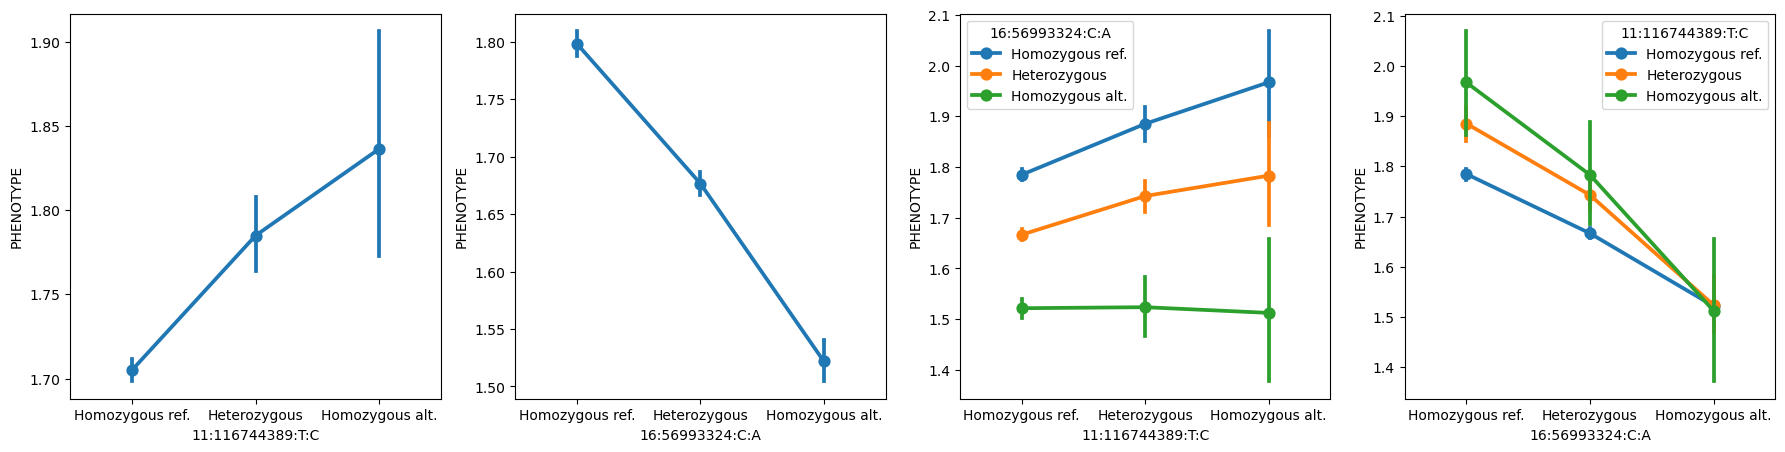

In [11]:
epistasis_finder.draw_epistasis('11:116744389:T:C', '16:56993324:C:A', phenotype='PHENOTYPE', sex=1) # put out_dir='path_to_save' to save figure as svg

## 2.2 Epistatic Sub-hierarchy Visualization

You can visualize epistasis under the target system

In [12]:
from src.utils.visualization.epistasis import EpistasisVisualizer

In [13]:
epistasis_visualizer = EpistasisVisualizer(tree_parser)

In [14]:
epistasis_results_genes = [[gene1, gene2] for snp1, gene1, snp2, gene2, p_val, adjusted_p_val in epistasis_results_with_genes]

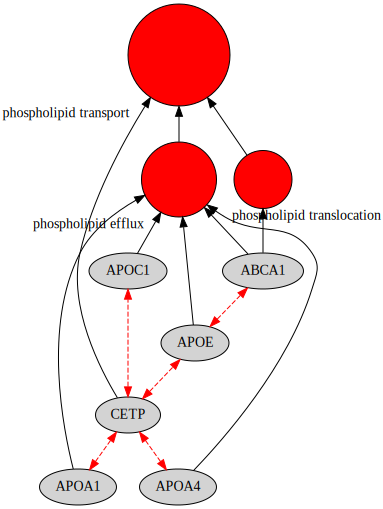

In [15]:
epistasis_visualizer.visualize_epistasis(target_system=target_system, epistatic_interactions=epistasis_results_genes)

# 3. Epistasis Analysis Result using LLM

In [16]:
from src.utils.analysis.llm_explainer import EpistaticInteractionExplainer

In [17]:
OPENAI_API_KEY = 'your_open_ai_api_key'

In [18]:
epistasis_explainer = EpistaticInteractionExplainer(OPENAI_API_KEY, model='chatgpt-4o-latest')

Put your target system, phenotype, and target genes

In [19]:
llm_result = epistasis_explainer.explain_epistasis(tree_parser.sys_annot_dict[target_system], 'TG/HDL ratio', 'APOA4', 'CETP')

Print out epistasis analysis from LLM

In [20]:
from IPython.display import Markdown as md

In [21]:
md(llm_result)

### **Analysis of Epistatic Interaction Between APOA4 and CETP in Phospholipid Transport**

#### **1. Biological Roles of APOA4 and CETP in Phospholipid Transport**
- **APOA4 (Apolipoprotein A-IV):**  
  - APOA4 is a key component of high-density lipoprotein (HDL) and chylomicrons.
  - It plays a role in lipid metabolism, particularly in the transport and regulation of phospholipids and triglycerides (TGs).
  - APOA4 is involved in reverse cholesterol transport, facilitating cholesterol efflux and influencing HDL metabolism.

- **CETP (Cholesteryl Ester Transfer Protein):**  
  - CETP mediates the transfer of cholesteryl esters from HDL to apolipoprotein B-containing lipoproteins (e.g., low-density lipoproteins (LDL) and very-low-density lipoproteins (VLDL)) in exchange for triglycerides.
  - This process modulates the composition of HDL and influences the TG/HDL ratio.
  - High CETP activity is often associated with reduced HDL levels and increased cardiovascular risk.

#### **2. Interaction and Influence on TG/HDL Ratio**
- APOA4 promotes HDL formation and cholesterol efflux, thereby reducing the TG/HDL ratio.
- CETP, on the other hand, facilitates the transfer of TGs into HDL while depleting HDL of cholesteryl esters, which ultimately lowers HDL cholesterol levels and increases the TG/HDL ratio.
- The balance between APOA4's HDL-promoting function and CETP's HDL-remodeling activity directly influences the TG/HDL phenotype.
- **Prediction:** If APOA4 activity increases or CETP activity decreases, the TG/HDL ratio should decrease, leading to a more favorable lipid profile.

#### **3. Possible Epistatic Relationships**
- **Antagonistic Epistasis (Opposing Effects):** APOA4 and CETP exhibit opposing roles in HDL metabolism. CETP reduces HDL levels by transferring cholesterol to TG-rich lipoproteins, while APOA4 enhances HDL formation and function.
- **Suppressive Epistasis:** Loss of CETP function (e.g., CETP inhibition) could suppress the effects of APOA4 loss by preventing HDL depletion, thereby maintaining a more balanced lipid profile.
- **Synthetic Interaction (Potential Compensation):** If both genes are knocked out, HDL formation may be severely impaired, leading to dysregulated lipid transport and increased cardiovascular risk.

#### **4. Phenotypic Effects of Gene Perturbations**
| **Perturbation** | **Expected TG/HDL Ratio Change** | **Phenotypic Implication** |
|-----------------|---------------------------------|---------------------------|
| **Loss of APOA4** | Increased TG/HDL ratio | Reduced HDL levels, impaired cholesterol efflux, higher cardiovascular risk |
| **Loss of CETP** | Decreased TG/HDL ratio | Increased HDL levels, potential cardioprotective effect |
| **Loss of both APOA4 and CETP** | Variable (depends on compensatory mechanisms) | HDL metabolism may be severely altered, possibly leading to lipid imbalance |
| **Overexpression of APOA4** | Decreased TG/HDL ratio | Increased HDL levels, improved lipid transport |
| **Overexpression of CETP** | Increased TG/HDL ratio | Decreased HDL levels, increased cardiovascular risk |

#### **Conclusion**
- APOA4 and CETP exhibit **antagonistic epistasis**, where CETP counteracts the HDL-promoting effects of APOA4.
- CETP inhibition may **suppress** the detrimental effects of APOA4 loss, suggesting a potential therapeutic strategy for improving lipid profiles.
- Double knockout effects are complex and may depend on compensatory pathways in lipid transport.

This analysis highlights how these two genes interact to shape the TG/HDL ratio and provides insights into potential genetic or pharmacological interventions.

**You can also visualize llm analysis as diagram!**

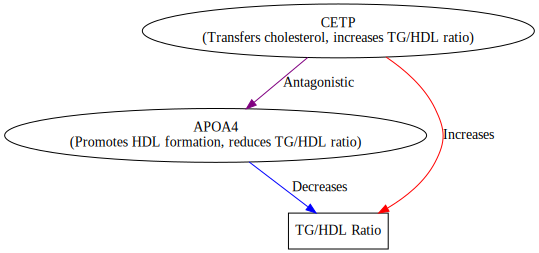

In [22]:
epistasis_explainer.visualize_epistasis_from_llm_analysis(llm_result)